# Vehicle Detection
----


## Import Packages

In [1]:
import sys
sys.version
sys.version_info

sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
import random
import glob
import time
import pickle

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.externals import joblib

from scipy.stats import linregress
from scipy.ndimage.measurements import label
from skimage.feature import hog
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
#import udacity lesson code (functions)
import udacity_features as uf
import udacity_window as uw
import udacity_plot3d as u3d
import udacity_heat as uh
import udacity_find_cars as ufc

In [4]:
#import previous projects functions
import car_roi
import car_hough
import car_roi
import car_camera
import car_histogram
import car_warp

Region of Interests functions OK
Hough function OK
Camera calibration functions OK
Warp Pipeline OK


---

## Major Parameters

In [42]:
### TODO: Tweak these parameters and see how the results change.
#color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
color_spaces = ["RGB", "HSV", "LUV", "HLS", "YUV", "YCrCb"] #["HSV", "YCrCb", "YUV"] #
orient = 11  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 0 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16,16) # Spatial binning dimensions
hist_bins = 8    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

CONST_CROP_X1 = 350
CONST_CROP_X2 = 656
CONST_CROP_Y1 = 300
CONST_CROP_Y2 = 1280

---

## Helper Functions

Below are some helper functions. Some of them are based on the first line lanes 
:)

In [6]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    
    for bbox in bboxes:
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # draw each bounding box on your image copy using cv2.rectangle()
    # return the image copy with boxes drawn
    return draw_img # Change this line to return image copy with boxes

In [7]:
# Define a function that takes an image and a list of templates as inputs
# then searches the image and returns the a list of bounding boxes 
# for matched templates
def find_matches(img, template_list):
    draw_img = img.copy() # Make a copy of the image to draw on
    bbox_list = [] # Define an empty list to take bbox coords
    
    for it in template_list: # Iterate through template list
        tmp = mpimg.imread(it) # Read in templates one by one
        res = cv2.matchTemplate(draw_img, tmp, cv2.TM_CCOEFF_NORMED) # Use cv2.matchTemplate() to search the image
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    
        w, h = (tmp.shape[1], tmp.shape[0])
        top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        bbox_list.append((top_left, bottom_right))

    # Use cv2.minMaxLoc() to extract the location of the best match
    # Determine bounding box corners for the match
    # Return the list of bounding boxes
    return bbox_list

In [8]:
def read_dataset(normalize=True, smallset=False):
    cars_path = 'dataset/vehicles/all/*.*'
    notcars_path = 'dataset/non-vehicles/all/*.*'
    
    if smallset == True:
        cars_path = 'dataset/cars-small/all/*.*'
        notcars_path = 'dataset/notcars-small/all/*.*'
    
    gl_cars = glob.glob(cars_path)
    gl_notcars = glob.glob(notcars_path)
    cars = []
    notcars = []

    for image in gl_cars:
        cars.append(image)

    for image in gl_notcars:
        notcars.append(image)

    if normalize == True:
        #keep cars and not cars lists with the same size
        len_cars = len(cars)
        len_notcars = len(notcars)

        if len_cars > len_notcars:
            for i in range(len_notcars, len_cars):
                rand = random.randint(0,len_notcars)
                image = notcars[rand]
                notcars.append(image)
        elif len_cars < len_notcars:
            for i in range(len_cars, len_notcars):
                rand = random.randint(0,len_cars)
                image = cars[rand]
                cars.append(image)
    
    return cars, notcars

In [9]:
def train_pipeline(color_spaces=[], normalize=True, smallset=False):
    #read dataset
    cars, notcars = read_dataset() #normalize, smallset)
    
    if len(color_spaces) == 0:
        color_spaces = ["RGB", "HSV", "LUV", "HLS", "YUV", "YCrCb"]
    
    for color_space in color_spaces:
        #extract features
        car_features = uf.extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        notcar_features = uf.extract_features(notcars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)

        X = np.vstack((car_features, notcar_features)).astype(np.float64)
        X_scaler = StandardScaler().fit(X) # Fit a per-column scaler
        scaled_X = X_scaler.transform(X) # Apply the scaler to X
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features)))) # Define the labels vector

        #define train set
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

        # Use a linear SVC 
        svc = LinearSVC()
        t=time.time()
        svc.fit(X_train, y_train)
        t2 = time.time()
    
        svc_filename = "svc-" + color_space + ".pkl"
        xscaler_filename = "xscaler-" + color_space + ".pkl"
    
        #save svc and x_scaler
        joblib.dump(svc, ("save-training/" + svc_filename))
        joblib.dump(X_scaler, ("save-training/" + xscaler_filename))
        
        print(color_space)
        print(round(t2-t, 2), 'Seconds to train SVC...')
        print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
        print("----")
        
#0.9763 RGB
#0.9892 HLS
#0.9892 LUV
#0.9871 LAB
#0.9871 HSV
#0.9914 YUV - 0.9957 (8 HIST_BIN) - 0.9935 (16 HIST_BIN) - (1.0 9ori, 8hist)
#0.9871 YCrCb

In [36]:
def window_pipeline(img):
    image = img[CONST_CROP_X1:CONST_CROP_X2, CONST_CROP_Y1:CONST_CROP_Y2]
    draw_image = np.copy(image)
    all_windows = []
    i = 1
    
    for color_space in color_spaces:
        svc_filename = "save-training/svc-" + color_space + ".pkl"
        xscaler_filename = "save-training/xscaler-" + color_space + ".pkl"
        
        svc = joblib.load(svc_filename)
        X_scaler = joblib.load(xscaler_filename)
        
        for factor in range(2,6):
            windows = uw.slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                                xy_window=(factor*32, factor*32), xy_overlap=(0.5, 0.5))

            hot_windows = uw.search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                    spatial_size=spatial_size, hist_bins=hist_bins, 
                                    orient=orient, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel, spatial_feat=True, 
                                    hist_feat=True, hog_feat=True)
        
            all_windows = all_windows + hot_windows
        
            draw_image = draw_boxes(draw_image, hot_windows, color=(40*i, (40*i), 40*i), thick=2)
        i += 1
    
    window_img = img.copy()
    window_img[CONST_CROP_X1:CONST_CROP_X2, CONST_CROP_Y1:CONST_CROP_Y2] = draw_image

    return window_img, all_windows
    

In [11]:
def heat_pipeline(img, hot_windows, heat_thresh=2):
    image = img[CONST_CROP_X1:CONST_CROP_X2, CONST_CROP_Y1:CONST_CROP_Y2]
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = uh.add_heat(heat, hot_windows) #box_list)

    # Apply threshold to help remove false positives
    heat = uh.apply_threshold(heat, heat_thresh)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = uh.draw_labeled_bboxes(np.copy(image), labels)
    
    heat_img = img.copy()
    heat_img[CONST_CROP_X1:CONST_CROP_X2, CONST_CROP_Y1:CONST_CROP_Y2] = draw_img
    
    heat_map = np.zeros_like(img[:,:,0]).astype(np.float)
    heat_map[CONST_CROP_X1:CONST_CROP_X2, CONST_CROP_Y1:CONST_CROP_Y2] = heatmap
    
    return heat_img, heat_map

In [61]:
CONST_PIPE_FRAMES_TO_RELOAD = 10
pp_index = 0
pp_last_img = None

def pipeline(img):
    global pp_index, pp_last_img
    
    if (pp_index == CONST_PIPE_FRAMES_TO_RELOAD) or pp_last_img is None:
        pp_index = 0
        
    if pp_index == 0:
        window_img, hot_windows = window_pipeline(img)
        heat_img, heatmap = heat_pipeline(img, hot_windows, heat_thresh=22)
        pp_last_img = heat_img
    
    pp_index += 1
    return pp_last_img

print('Pipeline OK')

Pipeline OK


## Test Images

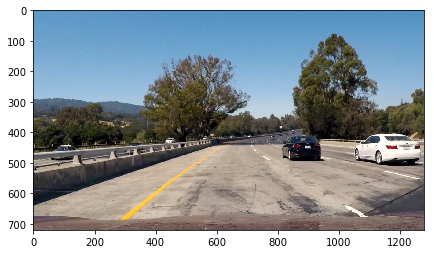

In [13]:
img_name = 'test_images/test1.jpg'
image = mpimg.imread(img_name)
plt.figure(figsize=(7,7))
plt.imshow(image)

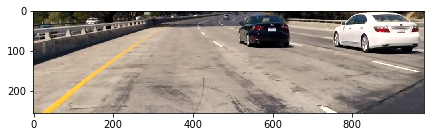

In [14]:
crop_img = image[CONST_CROP_X1:CONST_CROP_X2, CONST_CROP_Y1:CONST_CROP_Y2]
original_img = image.copy()
plt.figure(figsize=(7,7))
plt.imshow(crop_img)

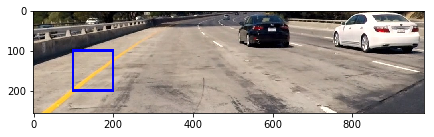

In [15]:
# Add random bounding boxes
bboxes = [((100, 100), (200, 200)), ((1000, 100), (1100, 200))]
result = draw_boxes(crop_img, bboxes)
plt.figure(figsize=(7,7))
plt.imshow(result)

In [16]:
# Read in car and non-car images
cars, notcars = read_dataset(normalize=False, smallset=False)
print(len(cars), len(notcars))

cars, notcars = read_dataset(normalize=True, smallset=False)
print(len(cars), len(notcars))

6941 8968
8968 8968


### Train set

In [17]:
'''
train_pipeline(color_spaces, True, False)
print('OK')
'''

"\ntrain_pipeline(color_spaces, True, False)\nprint('OK')\n"

## Test Pipeline

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LinearSVC from version 0.18.2 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.18.2 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


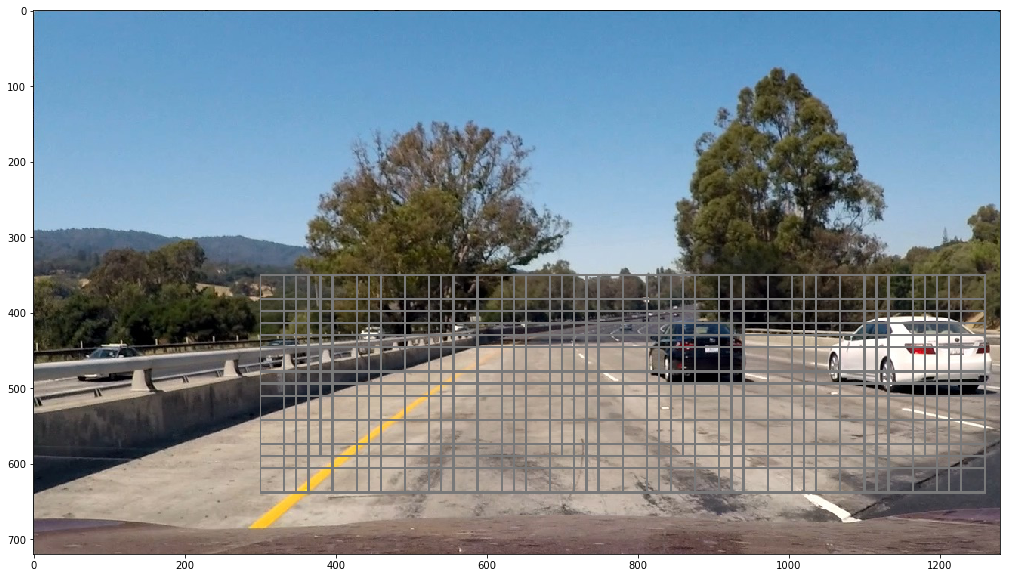

In [46]:
color_spaces = ["HSV", "YCrCb", "YUV"]
final_img, hot_windows = window_pipeline(original_img)

plt.figure(figsize=(20,10))
plt.imshow(final_img)

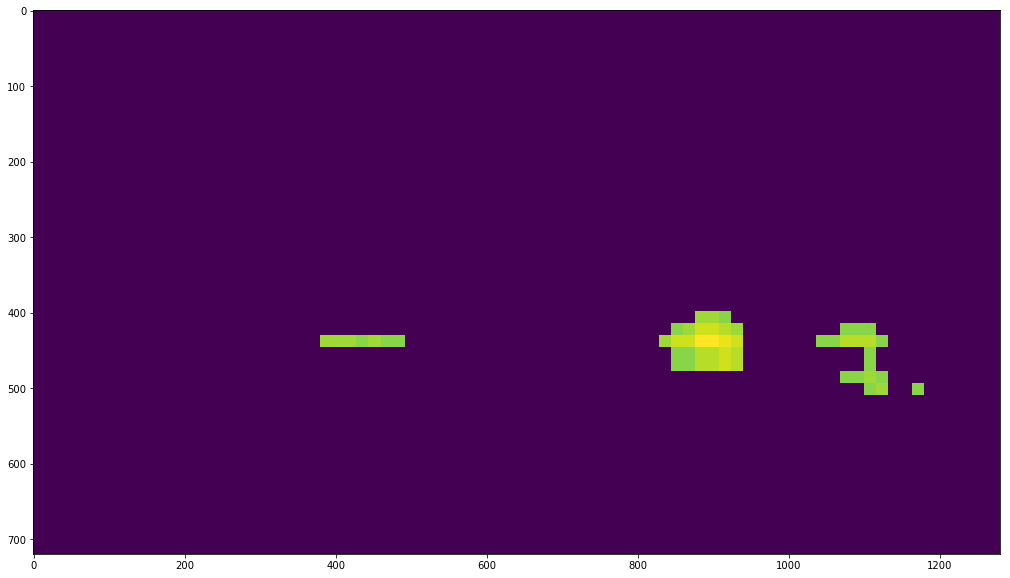

In [49]:
heat_img, heatmap = heat_pipeline(original_img, hot_windows, heat_thresh=22)

plt.figure(figsize=(20,10))
plt.imshow(heatmap)

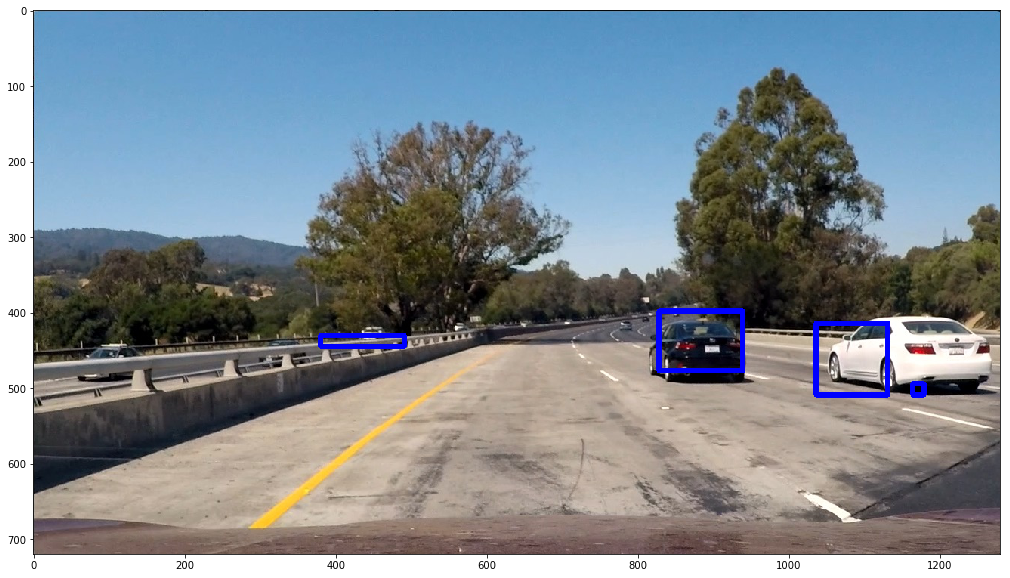

In [50]:
plt.figure(figsize=(20,10))
plt.imshow(heat_img)

In [ ]:
window_img, hot_img = pipeline(original_img)

fig = plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(window_img)
plt.subplot(122)
plt.imshow(hot_img, cmap='hot')

In [ ]:
'''
img = original_img.copy() #mpimg.imread('test_image.jpg')

ystart = 400
ystop = 656
scale = 1 #1.5
    
out_img = ufc.find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.figure(figsize=(20,10))
plt.imshow(out_img)
'''

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

Provided videos: `project_video.mp4`

In [51]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

Let's try the one with the solid white lane on the right first ...

In [62]:
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

pp_hist = False
video_output = 'output_test_video.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(pipeline).subclip(0,1) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_test_video.mp4
[MoviePy] Writing video output_test_video.mp4



 96%|█████████▌| 25/26 [00:38<00:01,  1.55s/it]

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_test_video.mp4 

CPU times: user 38.5 s, sys: 152 ms, total: 38.7 s
Wall time: 39.4 s


In [63]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

## Optional Challenge

Challenge the others videos.
`challenge_video.mp4`
`hard_challenge_video.mp4`